In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False, dtype='uint8')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [19]:
dataset = {
    'train': {}, 
    'test': {}
}

for group, data in [("train", mnist.train),("test", mnist.test)]:
    images, labels = preprocess(data.images, data.labels)
    dataset[group]['images'] = images
    dataset[group]['labels'] = labels

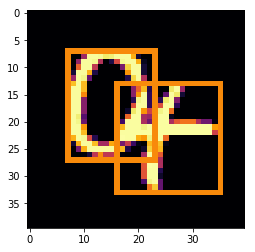

[[(7, 7), (23, 27)], [(16, 13), (35, 33)], 0, 4]

In [63]:
i = 10
img = dataset['train']['images'][i]
lbl = dataset['train']['labels'][i]
plotbbox(img, lbl)
lbl

In [71]:
for group in ['train', 'test']:
    images = dataset[group]['images']
    labels = dataset[group]['labels']
    for i in range(len(images)):
        writedata(i, images[i], labels[i], group)

In [46]:
temp.shape

(40, 40, 3)

In [69]:
obj_xml = '''
    <object>
        <name>{}</name>
        <bndbox>
            <xmin>{}</xmin>
            <ymin>{}</ymin>
            <xmax>{}</xmax>
            <ymax>{}</ymax>
        </bndbox>
    </object>\
'''

ann_xml = '''\
<annotation>
    <filename>{}</filename>
    <size>
        <width>40</width>
        <height>40</height>
        <depth>3</depth>
    </size>{}
</annotation>\
'''

def writedata(idx, image, label, group):
    imgdir = 'data/' + group + '/images/'
    lbldir = 'data/' + group + '/labels/'
    imgname = '{:05d}.png'.format(idx)
    xmlname = '{:05d}.xml'.format(idx)
    cv2.imwrite(imgdir + imgname, image)
    xml = ''
    for i in [0, 1]:
        true_label = label[i+2]
        xmin, ymin = label[i][0]
        xmax, ymax = label[i][1]
        xml += obj_xml.format(
            true_label, xmin, ymin, xmax, ymax)
    xml = ann_xml.format(imgname, xml)
    with open(lbldir + xmlname, 'x') as file:
        file.write(xml)
    
    
def preprocess(data, targets):
    images = []
    labels = []
    for i in range(data.shape[0]):
        idx1 = i
        idx2 = np.random.choice(data.shape[0])
        img1 = pickimg(data, idx1)
        img2 = pickimg(data, idx2)
        img, coords = combine(img1, img2)
        images.append(img)
        coords.extend([targets[idx1], targets[idx2]])
        labels.append(coords)
    return images, labels

def plotbbox(img, coords):
    tl1, br1 = coords[0]
    tl2, br2 = coords[1]
    cv2.rectangle(img, tl1, br1, (190, 190, 190), 1)
    cv2.rectangle(img, tl2, br2, (190, 190, 190), 1)
    plt.imshow(img, cmap='inferno')
    plt.show()
    
def combine(img1, img2, w=40):
    '''Overlay 2 images
    Returns:
        New image and bounding box locations
    '''
    img1 = croptobbox(img1)
    img2 = croptobbox(img2)
    img3 = np.zeros([w, w], 'uint8')
    i1, i2 = np.random.randint(15, 25, size=2)
    j1, j2 = np.random.randint(12, 16, size=2)
    mask = img2 > 0
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    i1 = i1 - h1//2
    i2 = i2 - h2//2
    j1 = j1 - w1//2
    j2 = j2 - w2//2 + 12
    img3[i1:i1+h1, j1:j1+w1] = img1
    img3[i2:i2+h2, j2:j2+w2][mask] = img2[mask]
    tl1 = j1, i1 # topleft row and column indices
    br1 = j1 + w1, i1 + h1 # bottom right
    tl2 = j2, i2
    br2 = j2 + w2, i2 + h2
    return img3, [[tl1, br1], [tl2, br2]]

def pickimg(images, index):
    '''Pick one from images'''
    return np.copy(images[index].reshape([28, 28]))

def findbbox(img):
    '''Find bounding rectangle
    Returns:
        Top left and bottom right row and column indices
    '''
    _, contours, _ = cv2.findContours(img, 1, 2)
    x, y, w, h = cv2.boundingRect(contours[-1])
    return y, x, y+h-1, x+w-1

def croptobbox(img):
    '''Crop image to bounding box size'''
    tl_i, tl_j, br_i, br_j = findbbox(img)
    return np.copy(img[tl_i:br_i+1, tl_j:br_j+1])